In [1]:
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.preprocessing import StandardScaler

### データ読み込み

In [2]:
train_kaggle = pd.read_csv('train_kaggle.csv')
train_kaggle.datetime = pd.to_datetime(train_kaggle.datetime)
train_kaggle.datetime.min(), train_kaggle.datetime.max()

(Timestamp('2017-06-09 00:00:00'), Timestamp('2018-09-30 00:00:00'))

 ### 目的変数をドルに変換

In [3]:
minimum_unit = train_kaggle.operation_value.abs().min()
train_kaggle['target'] = train_kaggle.operation_value / minimum_unit
train_kaggle['target'] = train_kaggle['target'].astype(int)
train_kaggle.head()

,datetime,atm_id,operation_type,client_id,operation_value,target
0,2017-08-05,85,0,20338,-0.294181,-19
1,2017-08-17,85,0,36294,4.412712,299
2,2017-08-22,85,0,45261,2.441701,165
3,2017-08-23,85,0,46317,-29.418080,-1999
4,2017-08-24,85,0,47522,2.941808,199


### とりあえず目的変数をヒストグラムに

119.44834847292755 -19999 19999


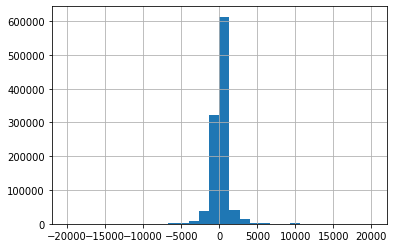

In [4]:
print(train_kaggle.target.mean(),train_kaggle.target.min(),train_kaggle.target.max(),)
train_kaggle.target.hist(bins=30);

In [ ]:
for atm_id in by_atm.keys():
    idx = by_atm[atm_id].datetime
    x = by_atm[atm_id].target
    plt.plot(idx, x);

### なんとなくヒートマップ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


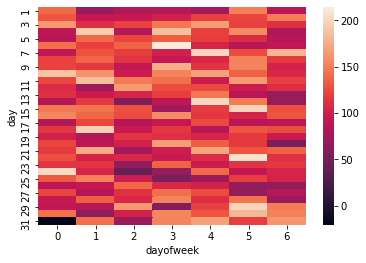

In [5]:
train_kaggle['dayofweek'] = train_kaggle.datetime.dt.dayofweek
train_kaggle['day'] = train_kaggle.datetime.dt.day
train_kaggle['month'] = train_kaggle.datetime.dt.month
train_kaggle['week'] = train_kaggle.datetime.dt.week
sns.heatmap(train_kaggle.pivot_table(index='day', columns='dayofweek', values='target'));

### ATM 別のトランザクション数

20


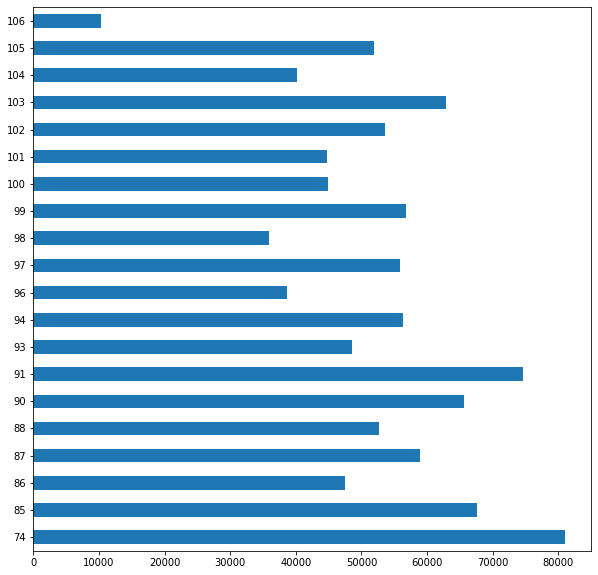

In [6]:

print(len(train_kaggle.atm_id.unique()))
train_kaggle.atm_id.value_counts()[[ 74,  85,  86,  87,  88,  90,  91,  93,  94,  96,  97,  98,  99,
            100, 101, 102, 103, 104, 105, 106]].plot(kind='barh', figsize=(10, 10));

### 適当に前処理

In [7]:
def read_weather_data(path):
    """
    pathのデフォルトは 'dailydata.csv'
    """
    weather_data = pd.read_csv(path, encoding='shift_jis')
    weather_data.datetime = pd.to_datetime(weather_data.datetime)
    weather_data = weather_data.drop(columns=['年', '月', '日'])
    return weather_data

def merge_weather_data(data, weather_data):
    return pd.merge(data, weather_data, how='inner', on='datetime')
    
    

def sumrize_daily_data(data):
        daily_data = data.pivot_table(
                                index=['datetime', 'atm_id', 'month', 'dayofweek', 'day'], 
                                values='target',
                                aggfunc='sum').reset_index()
        return daily_data

def add_poly_feature(data, target_feature, dim):
    """
    多項式回帰用: 指定したfeatureを次数dimまでの特徴量を追加する
    """
    if dim < 2:
        return data
    else:
        poly_feature = np.vstack([data[target_feature]**i for i in range(1, dim)]).T
        feature_names = [f'{target_feature}^{i}' for i in range(2, dim)]
        for i, feature_name in enumerate(feature_names):
            data[feature_name] = poly_feature[:, i]
        return data

def add_passed_date_feature(data, datefrom):
    """
    datefrom からの経過日数特徴量を追加する
    フォーマッt : YYYY-mm-dd
    """
    datefrom = dt.strptime(datefrom, '%Y-%m-%d')
    return (data.datetime - datefrom).dt.days

def add_salary10th(data):
    return data['day'].replace({10: 1, 1: 0, 2: 0, 3: 0, 4: 0
                                                   , 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 11: 0
                                                   , 12: 0, 13: 0, 14: 0, 15: 0, 16: 0
                                                   , 17: 0, 18: 0, 19: 0, 20: 0, 21: 0
                                                   , 22: 0, 23: 0, 24: 0, 25: 0, 26: 0
                                                   , 27: 0, 28: 0, 29: 0, 30: 0, 31: 0})

def add_salary25th(data):
    return data['day'].replace({25: 1, 1: 0, 2: 0, 3: 0, 4: 0
                                                   , 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 11: 0
                                                   , 12: 0, 13: 0, 14: 0, 15: 0, 16: 0
                                                   , 17: 0, 18: 0, 19: 0, 20: 0, 21: 0
                                                   , 22: 0, 23: 0, 24: 0, 10: 0, 26: 0
                                                   , 27: 0, 28: 0, 29: 0, 30: 0, 31: 0})


def preprocess(data):
    daily_data = sumrize_daily_data(data)
    weather_data = read_weather_data('dailydata.csv')
    daily_data = merge_weather_data(daily_data, weather_data)
    
    daily_data['passed_date'] = add_passed_date_feature(daily_data, '2017-06-09')
    # , :
    for col in ['passed_date', 'day', '日平均気温(℃)', '日最高気温(℃)', '日最低気温(℃)', '日降水量(mm)']:
        daily_data = add_poly_feature(daily_data, col, 5)
        
    daily_data['salary10th'] = add_salary10th(daily_data)
    daily_data['salary25th'] = add_salary25th(daily_data)    
    daily_data = pd.get_dummies(data=daily_data, columns=['dayofweek', 'month'], drop_first=True)
    return daily_data


def get_feature_target_cols(data):
    
    target_col = 'target'
    exclude_cols = ['target', 'datetime', 'client_id', 'operation_value', 'atm_id', 'operation_type']
    feature_cols = [col for col in data.columns if col not in exclude_cols]  # data_preprocessed には前処理ずみのデータを入れる
    
    return feature_cols, target_col


def split_by_atm(data):
    dataset_by_atm = {}
    for atm_id in data.atm_id.unique(): 
        is_target = atm_id == data.atm_id
        data_by_atm = data[is_target].reset_index(drop=True) 
        dataset_by_atm[atm_id] = data_by_atm
    return dataset_by_atm


def read_atm_data(path):
    data = pd.read_csv(path)
    data.datetime = pd.to_datetime(data.datetime)
    return data


def to_dollar(data):    
    minimum_unit = data.operation_value.abs().min()
    dollar = data.operation_value / minimum_unit
    dollar = dollar.astype(int)
    return dollar


def add_date_features(data):
    data['dayofweek'] = data.datetime.dt.dayofweek
    data['day'] = data.datetime.dt.day
    data['month'] = data.datetime.dt.month
#     data['week'] = data.datetime.dt.week
    return data

def data_preparation_main(path='train_kaggle.csv'):
    data = read_atm_data(path)
    data['target'] = to_dollar(data)
    data = add_date_features(data)
    preprocessed = preprocess(data)
    by_atm = split_by_atm(preprocessed)
    feature_cols, target_col = get_feature_target_cols(preprocessed)
    return preprocessed, by_atm, feature_cols,target_col

###  学習

In [8]:
def get_test_data(data):
    test_start_date = '2018-08-01'
    test_start_date = dt.strptime(test_start_date, '%Y-%m-%d')
    is_test = data.datetime >= ratio_date
    return data[is_test]

In [9]:
preprocessed, by_atm, feature_cols,target_col = data_preparation_main()

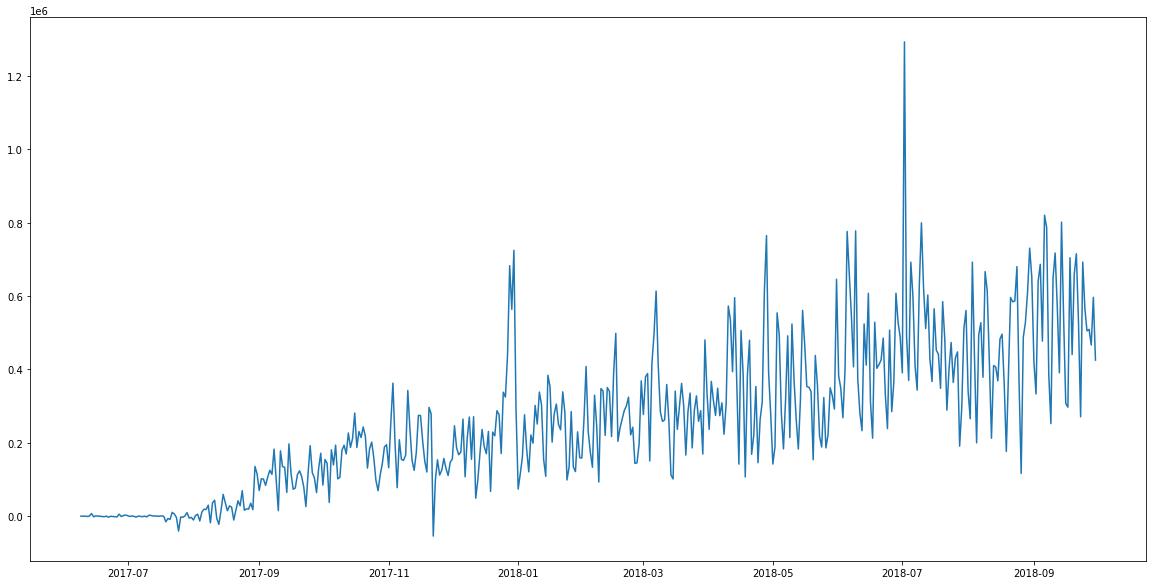

In [10]:
tmp = preprocessed.pivot_table(index='datetime', values='target', aggfunc='sum').reset_index()
idx = tmp.datetime
x = tmp.target

plt.figure(figsize=(20, 10))
plt.plot(idx, x);

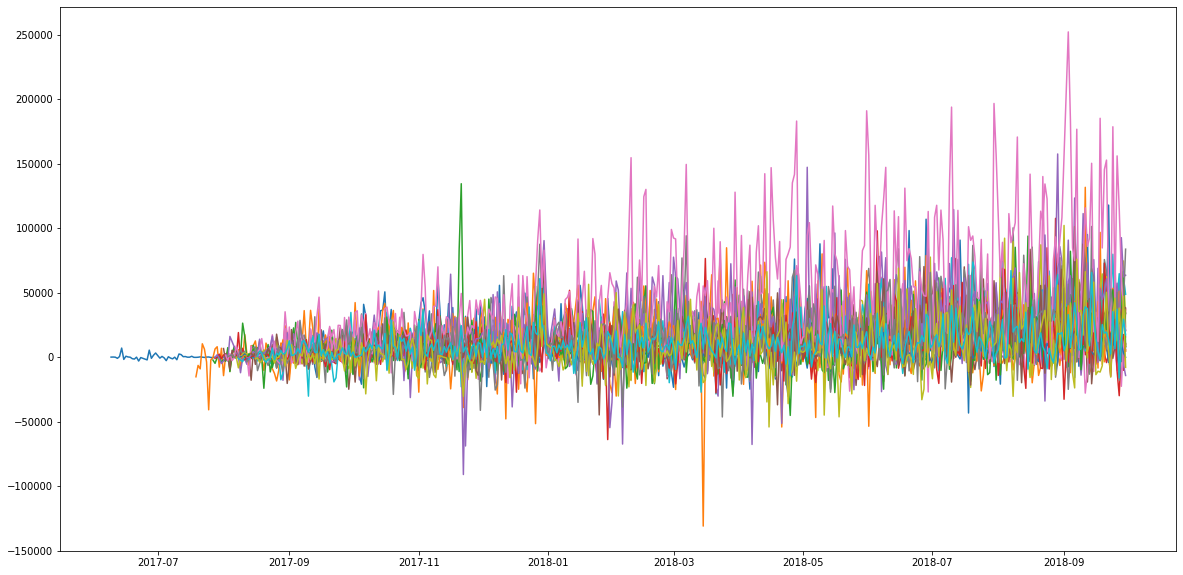

In [11]:
plt.figure(figsize=(20, 10))
for atm_id in by_atm.keys():
    idx = by_atm[atm_id].datetime
    x = by_atm[atm_id].target
    plt.plot(idx, x);

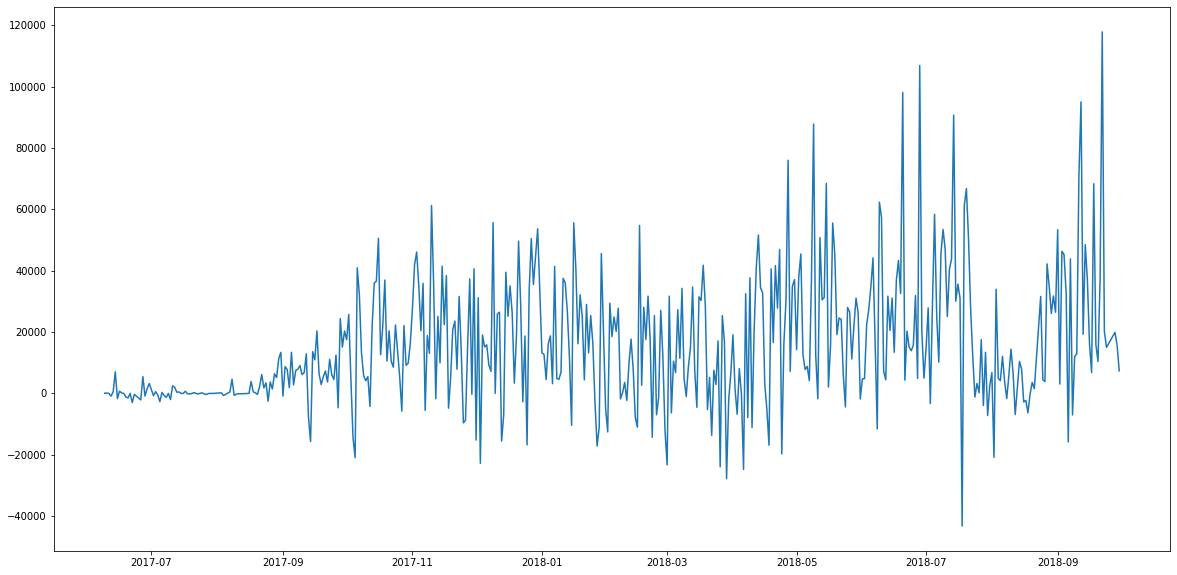

In [12]:
plt.figure(figsize=(20, 10))
# for atm_id in by_atm.keys():
idx = by_atm[87].datetime
x = by_atm[87].target
plt.plot(idx, x);

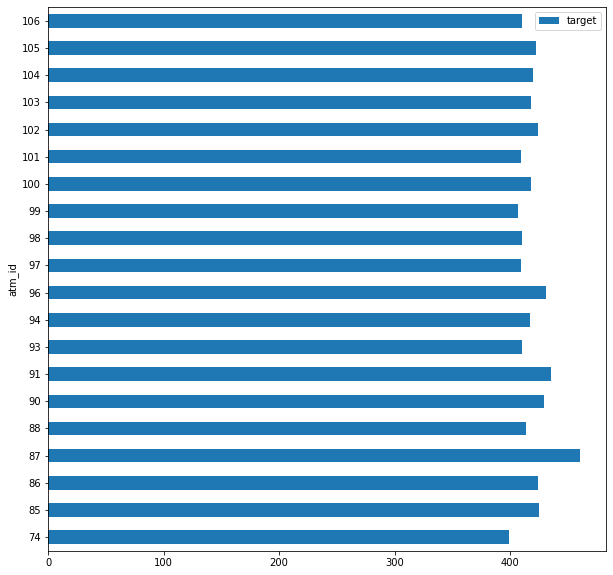

In [13]:
preprocessed.pivot_table(index='atm_id', values='target', aggfunc='count').plot(kind='barh', figsize=(10, 10))

In [14]:
is_test = preprocessed.datetime > '2018/07/31'
is_train = ~is_test

In [15]:
dataset = pd.get_dummies(preprocessed, columns=['atm_id'])
feature_cols_2, target = get_feature_target_cols(dataset)
X = dataset[feature_cols_2]
y = dataset[target]
X_train = X[is_train]
X_test = X[is_test]

y_train = y[is_train]
y_test = y[is_test]

In [16]:
test = dataset[is_test].sort_values(by='datetime')

In [17]:
date_by_atm = test.datetime

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [19]:
    ridge = Ridge(alpha=5)
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    rmse = np.sqrt(mse)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.57339e-18): result may not be accurate.
  overwrite_a=True).T


In [20]:
rmse

27598.666032176578

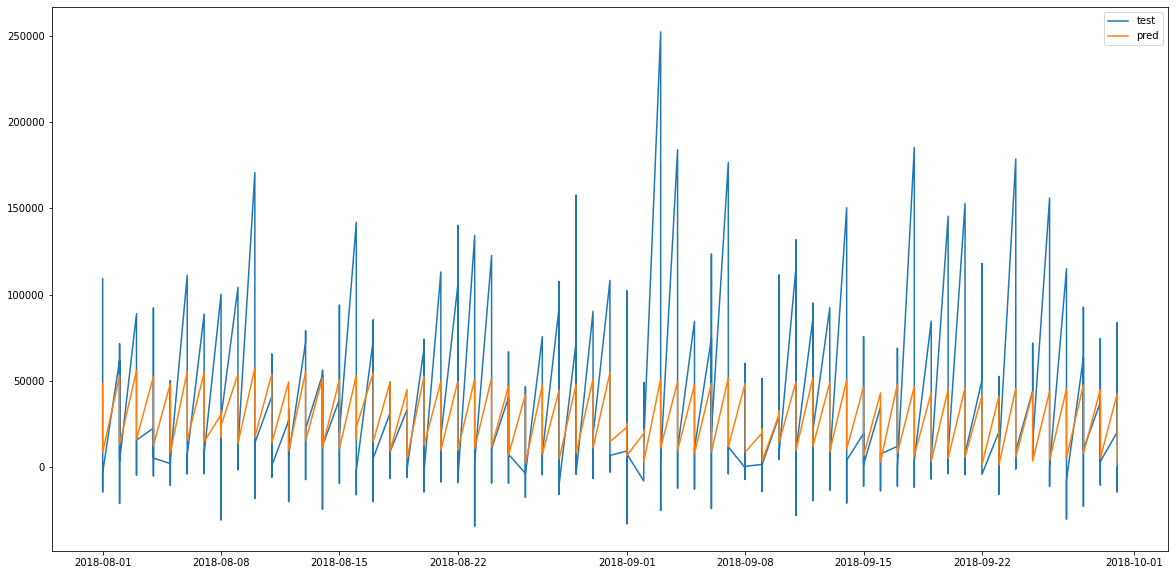

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(date_by_atm, y_test, label='test')
plt.plot(date_by_atm, pred, label='pred')
plt.legend();

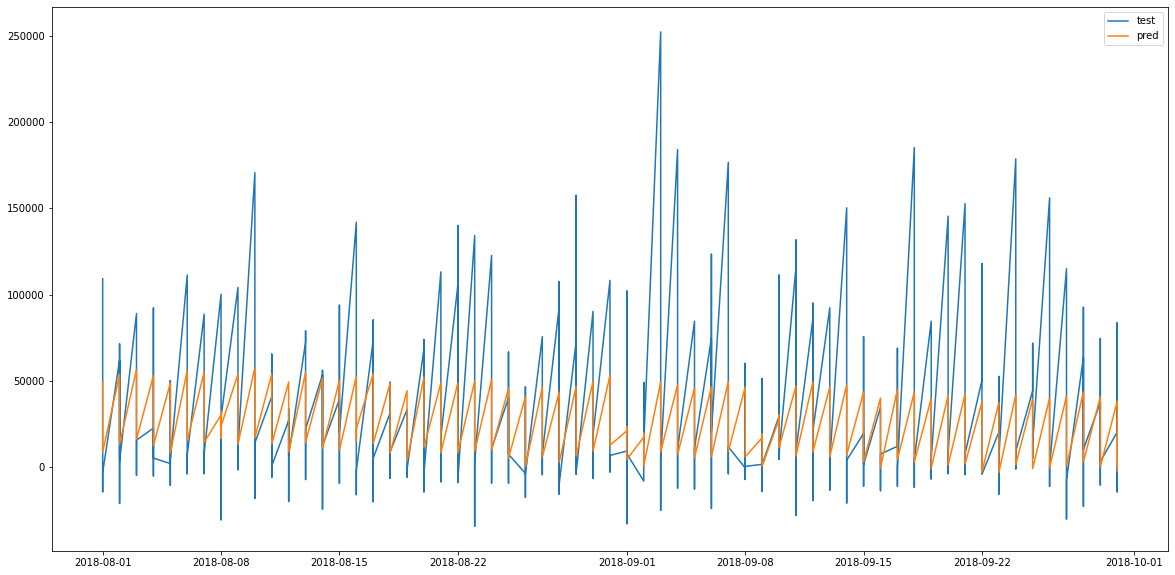

In [22]:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    rmse = np.sqrt(mse)

    plt.figure(figsize=(20, 10))
    plt.plot(date_by_atm, y_test, label='test')
    plt.plot(date_by_atm, pred, label='pred')
    plt.legend();

In [23]:
rmse

28375.898928932995

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=1234)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
rmse

24522.361444571354

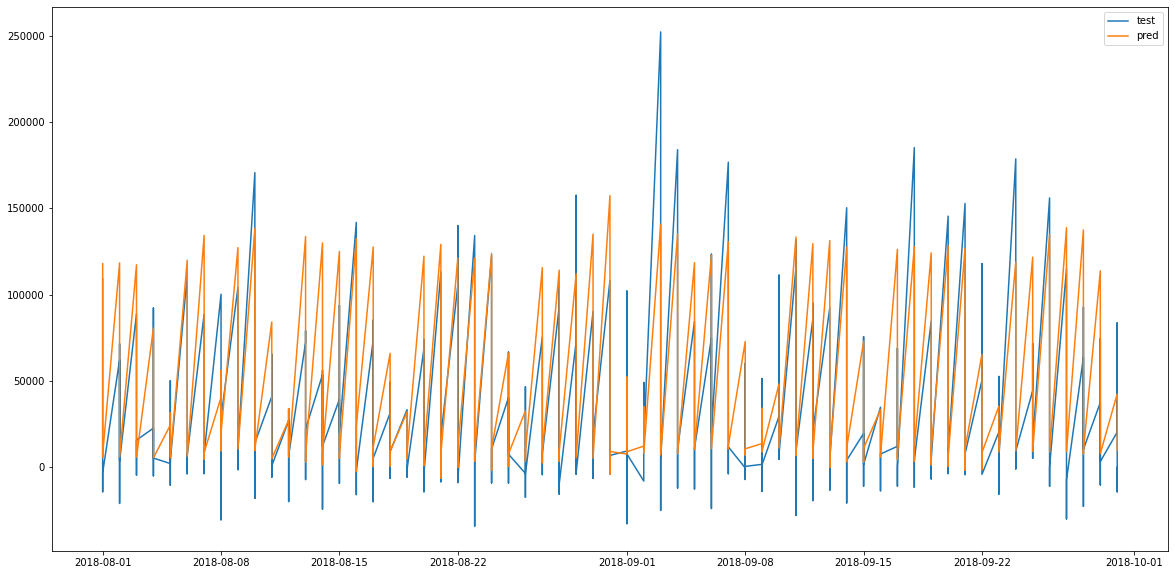

In [25]:
    plt.figure(figsize=(20, 10))
    plt.plot(date_by_atm, y_test, label='test')
    plt.plot(date_by_atm, pred, label='pred')
    plt.legend();

### pymc試す

In [ ]:
import scipy.stats as st

import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
by_atm[87].shape

(460, 46)

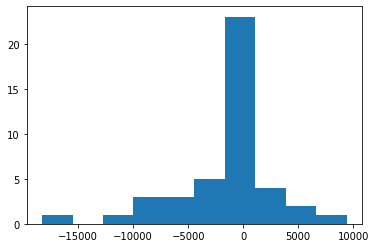

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor

train = by_atm[87]
X = train[feature_cols].values
y = train[target_col].values

lr = Lasso(alpha=1)
lr.fit(X, y)
plt.hist(lr.coef_);

https://note.com/kanawoinvestment/n/n7658c0a83f6c

In [ ]:
def get_date_bucket(x):
    if x < 10:
        return 'month_head'
    elif x < 20:
        return 'month_mid'
    else:
        return 'month_end'

In [ ]:
feature_for_sd = [
 'passed_date', 
 'dayofweek_1',
 'dayofweek_2',
 'dayofweek_3',
 'dayofweek_4',
 'dayofweek_5',
 'dayofweek_6',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'salary10th',
 'salary25th',
 'month_head',
 'month_mid',
 'month_end']

In [ ]:
feature_cols

['day',
 '日平均気温(℃)',
 '日最高気温(℃)',
 '日最低気温(℃)',
 '日降水量(mm)',
 'passed_date',
 'passed_date^2',
 'passed_date^3',
 'passed_date^4',
 'day^2',
 'day^3',
 'day^4',
 '日平均気温(℃)^2',
 '日平均気温(℃)^3',
 '日平均気温(℃)^4',
 '日最高気温(℃)^2',
 '日最高気温(℃)^3',
 '日最高気温(℃)^4',
 '日最低気温(℃)^2',
 '日最低気温(℃)^3',
 '日最低気温(℃)^4',
 '日降水量(mm)^2',
 '日降水量(mm)^3',
 '日降水量(mm)^4',
 'salary10th',
 'salary25th',
 'dayofweek_1',
 'dayofweek_2',
 'dayofweek_3',
 'dayofweek_4',
 'dayofweek_5',
 'dayofweek_6',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [ ]:
train = by_atm[87]
X = train[feature_cols].values
y = train[target_col].values

train['month_head'] = (train['day'] <= 10).astype(int)
train['month_mid'] = ((10 < train['day'])&(train['day'] <= 20)).astype(int)
train['month_end'] = (20 < train['day']).astype(int)    

X_for_sd = train[feature_for_sd].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_for_sd = scaler.fit_transform(X_for_sd)

X = scaler.fit_transform(X)

KeyError: "['atm_id_86', 'atm_id_96', 'atm_id_99', 'atm_id_88', 'atm_id_97', 'atm_id_105', 'atm_id_106', 'atm_id_101', 'atm_id_104', 'atm_id_93', 'atm_id_91', 'atm_id_90', 'atm_id_74', 'atm_id_85', 'atm_id_87', 'atm_id_98', 'atm_id_100', 'atm_id_94', 'atm_id_102', 'atm_id_103'] not in index"

In [ ]:
N = train['passed_date'].max()
date = train['passed_date'].values

In [ ]:
with pm.Model() as model:    
    # 回帰係数
    mu_w_1 = pm.Uniform('mu_w_1', lower=-1000, upper=1000, shape=len(feature_cols))
    mu_w_2 = pm.Uniform('mu_w_2', lower=-1000, upper=1000, shape=len(feature_cols))
    
    # 切片
    mu_intercept_1 = pm.Uniform('mu_intercept_1', lower=-1000, upper=1000,)
    mu_intercept_2 = pm.Uniform('mu_intercept_2', lower=-1000, upper=1000,)
    
    # y = α + βX
    mu_1 = pm.math.dot(X, mu_w_1) + mu_intercept_1
    mu_2 = pm.math.dot(X, mu_w_2) + mu_intercept_2
    
    #  y の変化点
    mu_tau = pm.DiscreteUniform('mu_tau', lower=0, upper=N)
    mu = pm.Deterministic('mu', pm.math.switch(mu_tau > date, mu_1, mu_2))
        
    # 分散の重み
    sd_w_1 = pm.Uniform('sd_w_1', lower=-1000, upper=1000, shape=len(feature_for_sd))
    sd_w_2 = pm.Uniform('sd_w_2', lower=-1000, upper=1000, shape=len(feature_for_sd))
    sd_intercept_1 = pm.Uniform('sd_intercept_1', lower=-1000, upper=1000)
    sd_intercept_2 = pm.Uniform('sd_intercept_2', lower=-1000, upper=1000)
    
    # 分散を線形結合で求める
    sd_1 = pm.math.dot(X_for_sd, sd_w_1) + sd_intercept_1
    sd_2 = pm.math.dot(X_for_sd, sd_w_2) + sd_intercept_2
    
    #  sdの変化点
    sd_tau = pm.DiscreteUniform('sd_tau', lower=0, upper=N)
    sd = pm.Deterministic('sd', pm.math.switch(sd_tau > date, sd_1, sd_2))
    
    pm_y = pm.Normal('pm_y', mu=mu, sd=pm.math.exp(sd), observed=y)

In [ ]:
# np.exp(-100)

In [ ]:
with model:
    trace = pm.sample(draws=1000, chains=1, step=pm.Metropolis())

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd_tau]
>Metropolis: [sd_intercept_2]
>Metropolis: [sd_intercept_1]
>Metropolis: [sd_w_2]
>Metropolis: [sd_w_1]
>Metropolis: [mu_tau]
>Metropolis: [mu_intercept_2]
>Metropolis: [mu_intercept_1]
>Metropolis: [mu_w_2]
>Metropolis: [mu_w_1]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 99 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
trace.varnames

['mu_w_1_interval__',
 'mu_w_2_interval__',
 'mu_intercept_1_interval__',
 'mu_intercept_2_interval__',
 'mu_tau',
 'sd_w_1_interval__',
 'sd_w_2_interval__',
 'sd_intercept_1_interval__',
 'sd_intercept_2_interval__',
 'sd_tau',
 'mu_w_1',
 'mu_w_2',
 'mu_intercept_1',
 'mu_intercept_2',
 'mu',
 'sd_w_1',
 'sd_w_2',
 'sd_intercept_1',
 'sd_intercept_2',
 'sd']

In [ ]:
az.summary(trace, var_names=['mu_tau', 'sd_tau'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_tau,300.095,9.795,284.0,318.0,0.768,0.544,160.0,147.0,NaN
sd_tau,112.546,3.121,106.0,118.0,0.865,0.631,12.0,24.0,NaN


In [ ]:
coef_result = az.summary(trace, var_names=['mu_w_1', 'mu_w_2'])
coef_result['feature_name'] = feature_cols * 2
coef_result

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,feature_name
mu_w_1[0],426.374,364.919,-534.239,808.314,194.255,150.645,5.0,20.0,NaN,day
mu_w_1[1],-944.946,43.020,-985.171,-887.166,13.037,9.759,8.0,24.0,NaN,日平均気温(℃)
mu_w_1[2],-85.705,438.736,-804.694,546.277,350.393,318.498,2.0,15.0,NaN,日最高気温(℃)
mu_w_1[3],-986.437,9.230,-999.572,-972.420,3.264,2.404,7.0,13.0,NaN,日最低気温(℃)
mu_w_1[4],797.756,284.482,106.764,973.173,136.014,112.253,5.0,12.0,NaN,日降水量(mm)
...,...,...,...,...,...,...,...,...,...,...
mu_w_2[38],-321.313,410.591,-876.788,457.603,85.713,61.396,24.0,90.0,NaN,month_8
mu_w_2[39],494.147,512.369,-410.695,987.848,234.777,199.718,4.0,37.0,NaN,month_9
mu_w_2[40],-629.936,304.926,-956.857,-115.152,61.028,43.668,26.0,53.0,NaN,month_10
mu_w_2[41],-258.825,510.955,-958.806,779.200,110.075,78.913,19.0,20.0,NaN,month_11


In [ ]:
az.summary(trace, var_names=['sd_w_1', 'sd_w_2'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sd_w_1[0],0.459,0.274,0.087,1.025,0.213,0.191,2.0,11.0,NaN
sd_w_1[1],-0.070,0.175,-0.347,0.252,0.151,0.147,1.0,33.0,NaN
sd_w_1[2],-0.037,0.160,-0.223,0.296,0.127,0.115,2.0,18.0,NaN
sd_w_1[3],-0.096,0.116,-0.302,0.123,0.080,0.066,2.0,24.0,NaN
sd_w_1[4],-0.394,0.127,-0.562,-0.153,0.103,0.098,2.0,22.0,NaN
sd_w_1[5],-0.281,0.119,-0.502,-0.079,0.040,0.029,9.0,22.0,NaN
sd_w_1[6],-0.233,0.114,-0.440,-0.071,0.042,0.031,15.0,11.0,NaN
sd_w_1[7],0.977,0.167,0.763,1.321,0.099,0.079,3.0,11.0,NaN
sd_w_1[8],0.990,0.223,0.607,1.312,0.177,0.161,2.0,28.0,NaN
sd_w_1[9],1.861,0.162,1.530,2.182,0.102,0.083,3.0,12.0,NaN


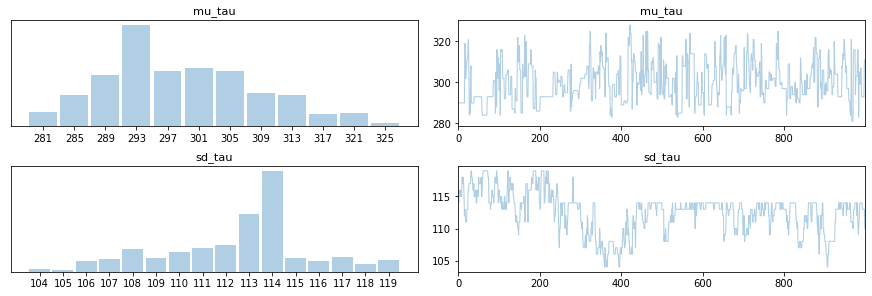

In [ ]:
az.plot_trace(trace, var_names=['mu_tau', 'sd_tau']);

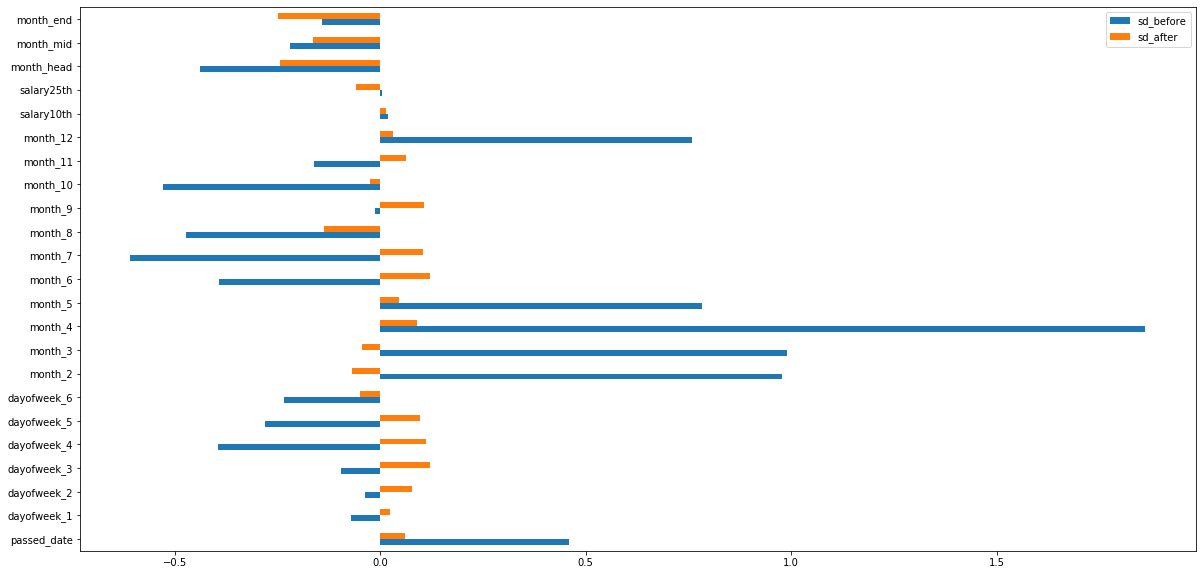

In [ ]:
sd_w_dataframe = pd.DataFrame(index=feature_for_sd, data={'sd_before': trace['sd_w_1'].mean(axis=0), 'sd_after':trace['sd_w_2'].mean(axis=0)})
sd_w_dataframe.plot(kind='barh', figsize=(20, 10));

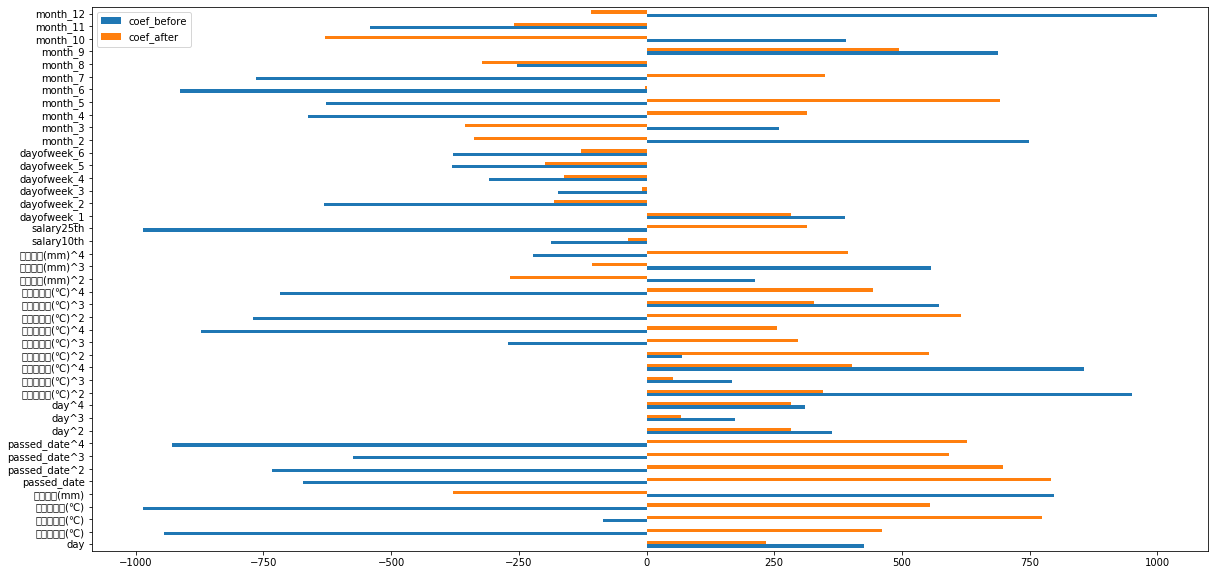

In [ ]:
coef_w_dataframe = pd.DataFrame(index=feature_cols, data={'coef_before': trace['mu_w_1'].mean(axis=0), 'coef_after':trace['mu_w_2'].mean(axis=0)})
coef_w_dataframe.plot(kind='barh', figsize=(20, 10));


In [ ]:
sd_tau_matrix = np.ones([len(date), len(trace['sd_tau'])])
sd_tau = ((sd_tau_matrix * trace['sd_tau']).T > date).mean(axis=0)

sd_1 = X_for_sd @ trace['sd_w_1'].mean(axis=0) + trace['sd_intercept_1'].mean()
sd_2 = X_for_sd @ trace['sd_w_2'].mean(axis=0) + trace['sd_intercept_2'].mean()

sd_before = sd_1 * sd_tau
sd_after = sd_2 * (1 - sd_tau)

sd = sd_before + sd_after
# sd

In [ ]:
mu_tau_matrix = np.ones([len(date), len(trace['mu_tau'])])
mu_tau = ((mu_tau_matrix * trace['mu_tau']).T > date).mean(axis=0)

mu_1 = X @ trace['mu_w_1'].mean(axis=0) + trace['mu_intercept_1'].mean()
mu_2 = X @ trace['mu_w_2'].mean(axis=0) + trace['mu_intercept_2'].mean()

mu_before = mu_1 * mu_tau
mu_after = mu_2 * (1 - mu_tau)

mu = mu_before + mu_after
# mu

In [ ]:
# sd

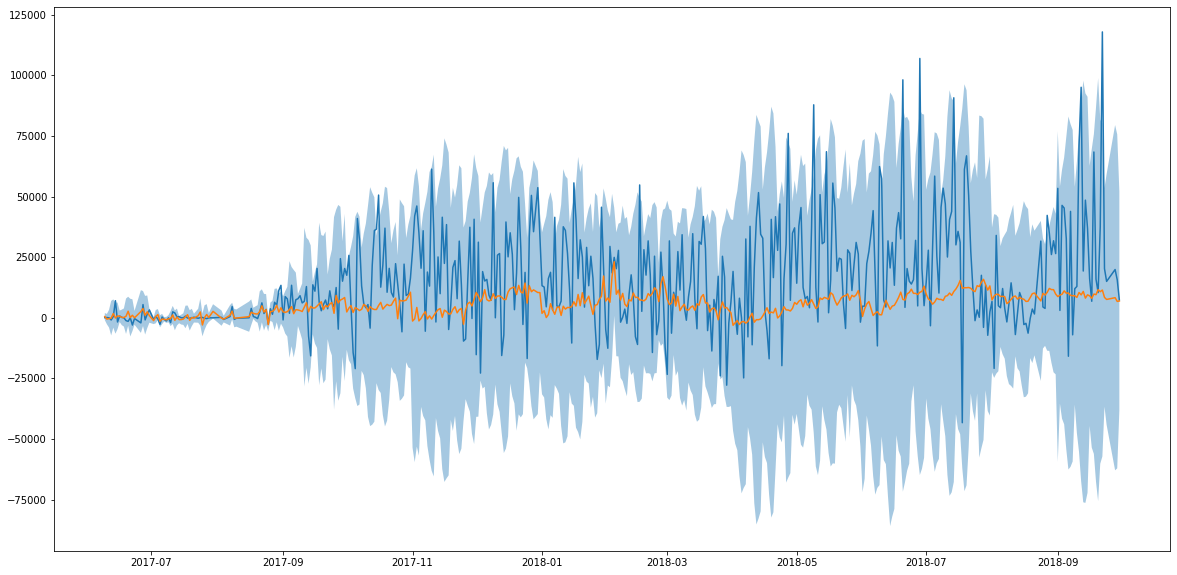

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train.datetime, train.target)
plt.plot(train.datetime, mu)

plt.fill_between(train.datetime, mu + (1.96 * np.exp(sd)), mu - (1.96 * np.exp(sd)), alpha=0.4);